# 0. Load packages and imports

In [55]:
## basic functionality
import pandas as pd
import numpy as np
import re
import plotnine
from plotnine import *

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Individual portion

Use the same `sentencing_cleaned` data for this portion. 

In the group portion, you investigated one form of disparity: probation versus incarceration.

Here, you'll investigate a second type of disparity---the length of a defendant's sentence---and also investigate how variation between different judges in the severity of the sentence relates to disparities. 

## 3.1 Filter to incarceration and construct a sentence length variable (6 points)

Defendants can be sentenced to different lengths for probation, but for simplicity:

- Filter to sentences that involve incarceration (same Illinois Department of Corrections logic as above)
- Filter out non-numeric sentence lengths (e.g., Term, Pounds, or Dollars)
- Filter to Black or White defendants

Then, follow the instructions in the codebook (combining `COMMITMENT_TERM` with `COMMITMENT_UNIT`) to create a standard sentence length in days column (`senlength_derived`). To simplify, you can assume that:

- 1 hour = 1/24th of a day
- 1 year = 365 days
- 1 month = 30.5 days
- 1 week = 7 days
- Natural life = difference between the age of 100 and the defendant's age at incident (cleaned; if missing, code to age 20); note that this is a simplification since age at incident != age at sentencing 

Print the following cols for an example of each type (eg an example of originally hours; an example of natural life): `COMMITMENT_TERM`, `COMMITMENT_UNIT`, `age_derived` and your new standardized sentence length column

Print the summary of that sentence length column using the .describe() command

In [56]:
sentencing = pd.read_csv("~/qss20_mywork/pset1/sentencing_cleaned.csv")

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (10,11,14,16,23,25,41,43,44,45,46,47) have mixed types.Specify dtype option on import or set low_memory=False.


In [57]:
sentencing = sentencing[sentencing["COMMITMENT_TYPE"]== "Illinois Department of Corrections"]
sentencing = sentencing[~sentencing["COMMITMENT_UNIT"].isin(["Term","Pounds","Dollars"])]
sentencing = sentencing[sentencing["is_white_derived"] | sentencing["is_black_derived"]]

sentencing["COMMITMENT_TERM"] = pd.to_numeric(sentencing["COMMITMENT_TERM"])

terms = [sentencing["COMMITMENT_UNIT"] == "Hours",
         sentencing["COMMITMENT_UNIT"] == "Year(s)",
         sentencing["COMMITMENT_UNIT"] == "Months",
         sentencing["COMMITMENT_UNIT"] == "Weeks",
         sentencing["COMMITMENT_UNIT"] == "Days",
         (sentencing["COMMITMENT_UNIT"] == "Natural Life") & (sentencing['AGE_AT_INCIDENT'].notnull()),
         (sentencing["COMMITMENT_UNIT"] == "Natural Life") & (sentencing['AGE_AT_INCIDENT'].isna())]

units = [sentencing["COMMITMENT_TERM"] / 24,
         sentencing["COMMITMENT_TERM"] * 365,
         sentencing["COMMITMENT_TERM"] * 30.5,
         sentencing["COMMITMENT_TERM"] * 7,
         sentencing["COMMITMENT_TERM"],
         100-sentencing['AGE_AT_INCIDENT'],
         80]
         
sentencing["senlength_derived"] = np.select(terms, units, None)

sentencing["senlength_derived"] = pd.to_numeric(sentencing["senlength_derived"])


In [58]:
sentencing.groupby("COMMITMENT_UNIT")[["COMMITMENT_TERM", "senlength_derived"]].first()
sentencing["senlength_derived"].describe()

,COMMITMENT_TERM,senlength_derived
COMMITMENT_UNIT,,
Days,90.0,90.000000
Hours,1.0,0.041667
Months,18.0,549.000000
Natural Life,1.0,70.000000
Weeks,2.0,14.000000
Year(s),62.0,22630.000000


count     44639.000000
mean       1438.190193
std        2018.256817
min           0.000000
25%         457.500000
50%        1095.000000
75%        1460.000000
max      147825.000000
Name: senlength_derived, dtype: float64

## 3.2 Examine disparities in length within the same judge and offense category: no adjustment (2 points)

- Filter to narcotics offenses 

- For each judge with at least 20 Black and at least 20 white defendants, plot the (1) median sentence length for Black defendants and (2) median sentence length for white defendants (factor variable on x axis for each judge_id who qualifies; group by race)

- Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?

In [59]:
sentencing = sentencing[sentencing["simplified_offense_derived"] == "Narcotics"]

judge_groupings = sentencing.groupby("judgeid_derived").agg({"is_black_derived": "sum", "is_white_derived": "sum"})
judge_groupings3_2 = judge_groupings[(judge_groupings.is_black_derived>= 20) & (judge_groupings.is_white_derived>= 20)]
judge_groupings3_2

,is_black_derived,is_white_derived
judgeid_derived,,
judge_166,21,24
judge_21,21,31
judge_320,260,21
judge_334,117,25
judge_35,74,20
judge_36,389,28
judge_41,28,51


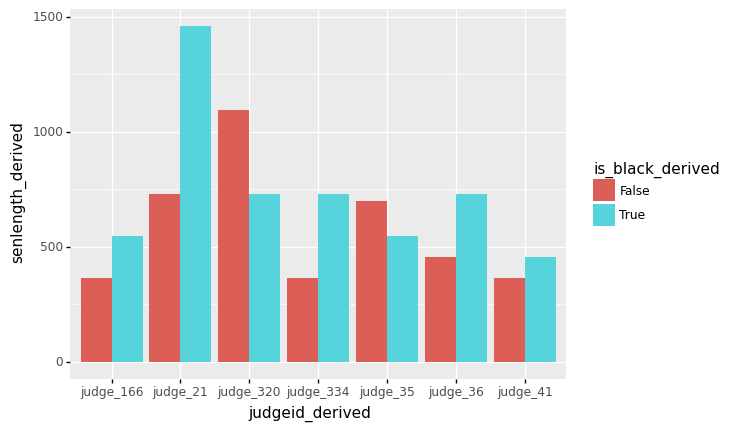

<ggplot: (8728065314100)>

In [60]:
mediansenlength = sentencing[sentencing["judgeid_derived"].isin(judge_groupings3_2.index)]
mediansenlength = mediansenlength.groupby(["judgeid_derived", "is_black_derived"]).senlength_derived.median().to_frame().reset_index()
#mediansenlength

plot = ggplot(mediansenlength, aes(x="judgeid_derived", y = "senlength_derived", fill = "is_black_derived")) + geom_bar(stat="identity", position = "dodge")
plot

All but two judges gave longer median sentences to black defendants compared to white ones.  In particular, judge_21 tended to give far longer sentences in general than many of their peers - but black defendants' median sentences were nearly double that of their white counterparts.  Given that we assume cases are randomly assigned, this implies judicial discretion is a major part of the disparities in sentencing.

## 3.3 Examine disparities in length within the same judge and offense category: constructing matched pairs (6 points)

Focus on `judgeid_derived` = `judge_21` and the same narcotics offenses. For each defendant, you want to construct "matched groups" of defendants who:

- Are the same exact age
- Are the same gender
- Differ in race from the focal defendant

Use code to find any/all matched defendants for each focal defendant. Print a table that compares the sentence length for focal compared to others and comment on what other things you'd like to match on if we had a larger dataset
    

In [61]:
sentencing = sentencing[sentencing["judgeid_derived"] == "judge_21"]

for i in range(0, sentencing.shape[0]):
    
    matches = sentencing[sentencing["age_derived"] == sentencing.iloc[i]["age_derived"]]
    matches = matches[matches["GENDER"] == sentencing.iloc[i]["GENDER"]]
    matches = matches[matches["RACE"] != sentencing.iloc[i]["RACE"]]
    matches = matches.append(sentencing.iloc[i])
    matches[["age_derived", "GENDER", "RACE", "senlength_derived"]]
#Last row of each table is the focal defendant - tables with only one row means no matched defendants exist
#with a larger dataset, it would be very interesting to see the judge's race, age and gender as well

,age_derived,GENDER,RACE,senlength_derived
58381,21.0,Male,Black,1460.0
412,21.0,Male,White,1095.0


,age_derived,GENDER,RACE,senlength_derived
6904,17.0,Male,White,1095.0


,age_derived,GENDER,RACE,senlength_derived
57019,33.0,Male,Black,8760.0
21175,33.0,Male,White,1825.0


,age_derived,GENDER,RACE,senlength_derived
30015,20.0,Female,White,365.0


,age_derived,GENDER,RACE,senlength_derived
61939,32.0,Male,Black,1460.0
61940,32.0,Male,Black,1460.0
61941,32.0,Male,Black,1460.0
61942,32.0,Male,Black,1460.0
32289,32.0,Male,White,2190.0


,age_derived,GENDER,RACE,senlength_derived
61939,32.0,Male,Black,1460.0
61940,32.0,Male,Black,1460.0
61941,32.0,Male,Black,1460.0
61942,32.0,Male,Black,1460.0
32301,32.0,Male,White,2190.0


,age_derived,GENDER,RACE,senlength_derived
61939,32.0,Male,Black,1460.0
61940,32.0,Male,Black,1460.0
61941,32.0,Male,Black,1460.0
61942,32.0,Male,Black,1460.0
32302,32.0,Male,White,2190.0


,age_derived,GENDER,RACE,senlength_derived
40632,36.0,Male,White,1825.0


,age_derived,GENDER,RACE,senlength_derived
79738,29.0,Male,Black,1460.0
41448,29.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
43109,22.0,Male,Black,365.0


,age_derived,GENDER,RACE,senlength_derived
58381,21.0,Male,Black,1460.0
44766,21.0,Male,White,2555.0


,age_derived,GENDER,RACE,senlength_derived
44894,34.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
45804,19.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
47562,22.0,Male,Black,365.0


,age_derived,GENDER,RACE,senlength_derived
81801,24.0,Male,Black,2190.0
81892,24.0,Male,Black,2190.0
47992,24.0,Male,White,730.0


,age_derived,GENDER,RACE,senlength_derived
74782,25.0,Male,White,365.0
48366,25.0,Male,Black,1095.0


,age_derived,GENDER,RACE,senlength_derived
74782,25.0,Male,White,365.0
48546,25.0,Male,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
81801,24.0,Male,Black,2190.0
81892,24.0,Male,Black,2190.0
49418,24.0,Male,White,730.0


,age_derived,GENDER,RACE,senlength_derived
66907,28.0,Male,Black,1825.0
49532,28.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
50482,42.0,Male,Black,2190.0


,age_derived,GENDER,RACE,senlength_derived
63152,23.0,Male,White,365.0
51346,23.0,Male,Black,365.0


,age_derived,GENDER,RACE,senlength_derived
51777,35.0,Male,Black,365.0


,age_derived,GENDER,RACE,senlength_derived
81801,24.0,Male,Black,2190.0
81892,24.0,Male,Black,2190.0
53700,24.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
55416,41.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
56480,36.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
21175,33.0,Male,White,1825.0
57019,33.0,Male,Black,8760.0


,age_derived,GENDER,RACE,senlength_derived
57502,27.0,Male,Black,730.0


,age_derived,GENDER,RACE,senlength_derived
57587,28.0,Female,White,730.0


,age_derived,GENDER,RACE,senlength_derived
57589,28.0,Female,White,730.0


,age_derived,GENDER,RACE,senlength_derived
412,21.0,Male,White,1095.0
44766,21.0,Male,White,2555.0
61379,21.0,Male,White,365.0
58381,21.0,Male,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
60872,35.0,Female,White,730.0


,age_derived,GENDER,RACE,senlength_derived
58381,21.0,Male,Black,1460.0
61379,21.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
32289,32.0,Male,White,2190.0
32301,32.0,Male,White,2190.0
32302,32.0,Male,White,2190.0
61939,32.0,Male,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
32289,32.0,Male,White,2190.0
32301,32.0,Male,White,2190.0
32302,32.0,Male,White,2190.0
61940,32.0,Male,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
32289,32.0,Male,White,2190.0
32301,32.0,Male,White,2190.0
32302,32.0,Male,White,2190.0
61941,32.0,Male,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
32289,32.0,Male,White,2190.0
32301,32.0,Male,White,2190.0
32302,32.0,Male,White,2190.0
61942,32.0,Male,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
51346,23.0,Male,Black,365.0
63152,23.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
64674,26.0,Male,Black,365.0


,age_derived,GENDER,RACE,senlength_derived
49532,28.0,Male,White,365.0
66907,28.0,Male,Black,1825.0


,age_derived,GENDER,RACE,senlength_derived
67513,25.0,Female,White,1460.0


,age_derived,GENDER,RACE,senlength_derived
79738,29.0,Male,Black,1460.0
67872,29.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
68219,24.0,Female,White,365.0


,age_derived,GENDER,RACE,senlength_derived
68358,30.0,Female,White,1460.0


,age_derived,GENDER,RACE,senlength_derived
73082,39.0,Female,White,1095.0


,age_derived,GENDER,RACE,senlength_derived
74317,22.0,Male,Black,1095.0


,age_derived,GENDER,RACE,senlength_derived
48366,25.0,Male,Black,1095.0
48546,25.0,Male,Black,1460.0
74782,25.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
74872,23.0,Female,White,2190.0


,age_derived,GENDER,RACE,senlength_derived
77484,34.0,Female,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
41448,29.0,Male,White,365.0
67872,29.0,Male,White,365.0
79738,29.0,Male,Black,1460.0


,age_derived,GENDER,RACE,senlength_derived
80366,31.0,Male,White,365.0


,age_derived,GENDER,RACE,senlength_derived
47992,24.0,Male,White,730.0
49418,24.0,Male,White,730.0
53700,24.0,Male,White,365.0
81801,24.0,Male,Black,2190.0


,age_derived,GENDER,RACE,senlength_derived
47992,24.0,Male,White,730.0
49418,24.0,Male,White,730.0
53700,24.0,Male,White,365.0
81892,24.0,Male,Black,2190.0


# 4. Optional challenge: looking at judge characteristics

The previous exercises showed large differences in sentences between judges/differences in disparities. You become interested in how the judge's own demographic attributes are correlated with sentencing. Going back to the judge's name (`SENTENCE JUDGE`), parse their first name and try to probabilistically infer his or her gender. Then, investigate whether disparities differ between "likely female" and "likely male" judges. 

 